# RL Project - Highway

In this project I will train an agent to navigate on a highway, and hopefully avoid crashing. The OpenAI Gymnasium environment is called [HighwayEnv](https://github.com/Farama-Foundation/HighwayEnv) and is made by [Farama-Foundation](https://github.com/Farama-Foundation/).


> In this task, the ego-vehicle is driving on a multilane highway populated with other vehicles. The agent's objective is to reach a high speed while avoiding collisions with neighbouring vehicles. Driving on the right side of the road is also rewarded.
> -***HighwayEnv's GitHub repository***

&nbsp;

I was tasked with choosing one or more algorithms I will try, and explain my choice. I also have to train multiple algorithms (or the same algorithm using different hyperparameters)

---

In [1]:
import gymnasium
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

from keras.models import load_model

import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from stable_baselines3.common.evaluation import evaluate_policy

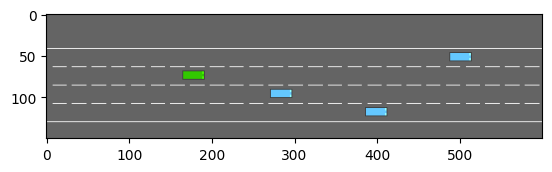

In [2]:
env = gymnasium.make('highway-v0', render_mode="rgb_array")
env.reset()

img = plt.imshow(env.render())

In [3]:
from gymnasium.wrappers import RecordVideo

## 0. Random actions

In [4]:
directory = "./videos/random"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)

observation = env.reset()
epochs = 0
penalties, reward = 0, 0
done = False

# max_epochs = 1000
# while not done and epochs < max_epochs:

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)

    if reward == -10:
        penalties += 1
    epochs += 1
    

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\random\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\random\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\random\rl-video-episode-0.mp4
Timesteps taken: 6
Penalties incurred: 0


## 1. **Deep Q-Networks (DQN) with `SB3`**

The first algorithm I will try out is Deep Q-Networks (DQN). The reasons for trying this algorithm are the following:

1. **Suitability for discrete action spaces**: DQN is well-suited for environments with discrete action spaces, where the agent must choose from a finite set of actions at each time step.
   
2. **Simplicity and ease of implementation**: DQN is relatively simple to understand and implement compared to some other advanced reinforcement learning algorithms.



The DQN algorithm is available in `stable_baselines3`, so I will try that because The `stable_baselines3` version of DQN is simpler to understand and implement than the non-SB3 version.

### Implementation

In [6]:
from stable_baselines3 import DQN

directory = "./videos/DQN-stable-baselines3"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)


dqn_model = DQN("MlpPolicy", env, verbose=0)
dqn_model.learn(total_timesteps=10000, log_interval=1000)
dqn_model.save("./models/dqn_sb3_model.keras")
dqn_model.save("./models/dqn_sb3_model")

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-8.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-27.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-27.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-64.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-64.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-125.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-125.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-216.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-216.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-343.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-343.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-512.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-512.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-729.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-729.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-729.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1000.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1000.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\DQN-stable-baselines3\rl-video-episode-1000.mp4


### Evaluate policy

In [7]:
evaluate_policy(dqn_model, env, n_eval_episodes=100)

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(8.293995829075575, 4.938060500188515)

## 2. **Proximal Policy Optimization (PPO) with `SB3`**


The second algorithm I will try out is Proximal Policy Optimization (PPO). The reasons for trying this algorithm are the following:

1. **Suitability for discrete action spaces**: DQN is well-suited for environments with discrete action spaces, where the agent must choose from a finite set of actions at each time step.
   
2. **Simplicity and ease of implementation**: PPO is also simple to understand and implement compared to some other advanced reinforcement learning algorithms.



The PPO algorithm is available in `stable_baselines3`, so I will try it out.

### Implementation

In [8]:
from stable_baselines3 import PPO

directory = "./videos/PPO-stable-baselines3"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)


ppo_model = PPO("MlpPolicy", env, verbose=0)
ppo_model.learn(total_timesteps=10000, log_interval=1000)
ppo_model.save("./models/ppo_sb3_model.keras")
ppo_model.save("./models/ppo_sb3_model")

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-1.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-8.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-27.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-27.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-64.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-64.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-125.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-125.mp4
Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-216.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-216.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-343.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-343.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-512.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\PPO-stable-baselines3\rl-video-episode-512.mp4


### Evaluation

In [9]:
evaluate_policy(ppo_model, env, n_eval_episodes=10)

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(28.649703979492188, 0.8709296344114532)

## 3. **Advantage Actor-Critic (A2C) with `SB3`**

A2C (Advantage Actor-Critic): A synchronous version of A3C (Asynchronous Advantage Actor-Critic), which updates the policy and value function using gradient descent.

### Implementation

In [10]:
from stable_baselines3 import A2C

directory = "./videos/A2C-stable-baselines3"
env = RecordVideo(gymnasium.make("highway-v0", render_mode="rgb_array"),
                  video_folder = directory)


a2c_model = A2C("MlpPolicy", env, verbose=0)
a2c_model.learn(total_timesteps=10000, log_interval=1000)
a2c_model.save("./models/a2c_sb3_model.keras")
a2c_model.save("./models/a2c_sb3_model")

Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-0.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-1.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-8.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-27.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-27.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-64.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-64.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-125.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-125.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-216.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-216.mp4


Moviepy - Building video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-343.mp4.
Moviepy - Writing video c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\Harman\Desktop\AI\Projects\RL Project - Highway\repository\videos\A2C-stable-baselines3\rl-video-episode-343.mp4


### Evaluation

In [11]:
evaluate_policy(a2c_model, env, n_eval_episodes=10)

c:\Users\Harman\miniconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(8.405015782825648, 3.775745934017255)

## 4. **Hindsight Experience Replay with `SB3`**


~~HER (Hindsight Experience Replay): A technique for improving sample efficiency in goal-reaching tasks by learning from "failed" experiences.~~


I wanted to implement this, but I couldn't make it work.